In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create a SparkSession
spark = SparkSession.builder.appName("Testing PySpark Example").getOrCreate()
# Set default session time zone to CET
spark.conf.set("spark.sql.session.timeZone", "Europe/Amsterdam")

In [2]:
from datetime import date, datetime
from decimal import Decimal

from pyspark.sql import Row

# fin_data with TrxId before RecDate
schema = "TrxDT Timestamp, CreditDebit String, AmountEuro Decimal(12,7), AccountName String, TrxId Integer, RecDate Date"
fin_data = [
    Row(
        TrxDT=datetime(2025, 3, 6, 20, 45, 19),
        CreditDebit="Credit",
        AmountEuro=Decimal(700.30),
        AccountName="Madame Zsa Zsa",
        TrxId=1,
        RecDate=date(2025, 3, 6),
    ),
    Row(
        TrxDT=datetime(2025, 3, 6, 12, 22, 1),
        CreditDebit="Debit",
        AmountEuro=Decimal(200.00),
        AccountName="Madame Zsa Zsa",
        TrxId=2,
        RecDate=date(2025, 3, 6),
    ),
    Row(
        TrxDT=datetime(2025, 3, 6, 20, 59, 0),
        CreditDebit="Debit",
        AmountEuro=Decimal(1110.20),
        AccountName="Madame Zsa Zsa",
        TrxId=3,
        RecDate=date(2025, 3, 6),
    ),
    Row(
        TrxDT=datetime(2025, 3, 6, 23, 50, 0),
        CreditDebit="Credit",
        AmountEuro=Decimal(50.00),
        AccountName="Madame Zsa Zsa",
        TrxId=4,
        RecDate=date(2025, 3, 7),
    ),
    Row(
        TrxDT=datetime(2025, 3, 6, 8, 0, 0),
        CreditDebit="Credit",
        AmountEuro=Decimal(1500.00),
        AccountName="Mr. X",
        TrxId=5,
        RecDate=date(2025, 3, 7),
    ),
    Row(
        TrxDT=datetime(2025, 3, 7, 14, 45, 0),
        CreditDebit="Debit",
        AmountEuro=Decimal(300.25),
        AccountName="Mr. X",
        TrxId=6,
        RecDate=date(2025, 3, 7),
    ),
    Row(
        TrxDT=datetime(2025, 3, 10, 9, 0, 0),
        CreditDebit="Credit",
        AmountEuro=Decimal(99.99),
        AccountName="Mr. X",
        TrxId=7,
        RecDate=date(2025, 3, 8),
    ),
]

df_a = spark.createDataFrame(fin_data, schema=schema)

# sepa_data with TrxId and RecDate
sepa_schema = "TrxId Integer, CountryCode String, RecDate Date"
sepa_data = [
    Row(TrxId=1, CountryCode="NL", RecDate=date(2025, 3, 5)),
    Row(TrxId=2, CountryCode="NL", RecDate=date(2025, 3, 4)),
    Row(TrxId=3, CountryCode="NL", RecDate=date(2025, 3, 6)),
    Row(TrxId=4, CountryCode="UK", RecDate=date(2025, 3, 7)),
    Row(TrxId=5, CountryCode="NL", RecDate=date(2025, 3, 12)),
    Row(TrxId=6, CountryCode="NL", RecDate=date(2025, 3, 18)),
    Row(TrxId=7, CountryCode="DE", RecDate=date(2025, 3, 6)),
]

df_b = spark.createDataFrame(sepa_data, schema=sepa_schema)

df_a.show(truncate=False)
df_b.show(truncate=False)

+-------------------+-----------+------------+--------------+-----+----------+
|TrxDT              |CreditDebit|AmountEuro  |AccountName   |TrxId|RecDate   |
+-------------------+-----------+------------+--------------+-----+----------+
|2025-03-06 20:45:19|Credit     |700.3000000 |Madame Zsa Zsa|1    |2025-03-06|
|2025-03-06 12:22:01|Debit      |200.0000000 |Madame Zsa Zsa|2    |2025-03-06|
|2025-03-06 20:59:00|Debit      |1110.2000000|Madame Zsa Zsa|3    |2025-03-06|
|2025-03-06 23:50:00|Credit     |50.0000000  |Madame Zsa Zsa|4    |2025-03-07|
|2025-03-06 08:00:00|Credit     |1500.0000000|Mr. X         |5    |2025-03-07|
|2025-03-07 14:45:00|Debit      |300.2500000 |Mr. X         |6    |2025-03-07|
|2025-03-10 09:00:00|Credit     |99.9900000  |Mr. X         |7    |2025-03-08|
+-------------------+-----------+------------+--------------+-----+----------+

+-----+-----------+----------+
|TrxId|CountryCode|RecDate   |
+-----+-----------+----------+
|1    |NL         |2025-03-05|
|2    

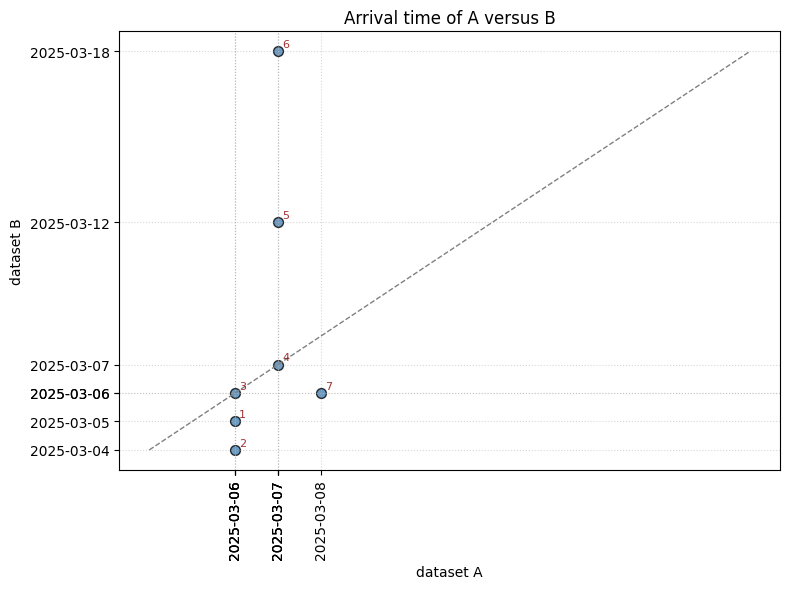

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Join on TrxId and convert to pandas
joined_pdf = (
    df_a.alias("a")
    .join(df_b.alias("s"), on="TrxId", how="inner")
    .select(
        col("a.RecDate").alias("fin_record_date"),
        col("s.RecDate").alias("sepa_record_date"),
        col("a.TrxId"),
    )
    .toPandas()
)

# Convert to pandas datetime
joined_pdf["fin_record_date"] = pd.to_datetime(joined_pdf["fin_record_date"])
joined_pdf["sepa_record_date"] = pd.to_datetime(joined_pdf["sepa_record_date"])

plt.figure(figsize=(8, 6))

# ✅ Add scatter plot (dots)
plt.scatter(
    joined_pdf["fin_record_date"],
    joined_pdf["sepa_record_date"],
    s=50,  # dot size
    color="steelblue",
    alpha=0.8,
    edgecolor="black",
)

# ✅ Diagonal reference line (y = x)
min_d = min(joined_pdf["fin_record_date"].min(), joined_pdf["sepa_record_date"].min())
max_d = max(joined_pdf["fin_record_date"].max(), joined_pdf["sepa_record_date"].max())
plt.plot([min_d, max_d], [min_d, max_d], linestyle="--", color="gray", linewidth=1)

# ✅ Annotate each point with TrxId
for _, row in joined_pdf.iterrows():
    plt.annotate(
        row["TrxId"],
        (row["fin_record_date"], row["sepa_record_date"]),
        xytext=(3, 3),
        textcoords="offset points",
        fontsize=8,
        color="darkred",
        alpha=0.8,
    )

# ✅ Axis and style
plt.xlabel("dataset A")
plt.ylabel("dataset B")
plt.title("Arrival time of A versus B")
plt.grid(True, linestyle=":", alpha=0.5)
plt.xticks(rotation=90)
plt.tight_layout()
plt.xticks(joined_pdf["fin_record_date"])
plt.yticks(joined_pdf["sepa_record_date"])

plt.show()